In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from timm.models.layers.adaptive_avgmax_pool import SelectAdaptivePool2d
from torch.nn import Flatten

from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.callback.fp16 import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 4.9 MB/s eta 0:00:0000:0100:01


In [2]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10011/220375232.png


In [4]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/462822612.png'

In [5]:
df.density.value_counts()

B    12651
C    12175
A     3105
D     1539
Name: density, dtype: int64

In [6]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/462822612.png,0
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/1459541791.png,0
2,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/1864590858.png,0
3,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10006/1874946579.png,0
4,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/10011/220375232.png,0


In [7]:
df.cancer.value_counts()

0    53548
1     1158
Name: cancer, dtype: int64

# Train Test Split

In [8]:
# from sklearn.model_selection import train_test_split

# # Split the data into training and testing sets, stratified by the "target" column
# train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['cancer'], random_state=1)
# print('shape of train_df', train_df.shape)
# print('shape of test_df', test_df.shape)

# Sampling

In [9]:
train_df=df.copy()
# Class count
count_class_0, count_class_1 = train_df.cancer.value_counts()

# Divide by class
df_class_0 = train_df[train_df['cancer'] == 0]
df_class_1 = train_df[train_df['cancer'] == 1]

In [10]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1, random_state=1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

df_train_under = df_train_under.sample(frac=1, random_state=1)

print('Random under-sampling:')
print(df_train_under.cancer.value_counts())

Random under-sampling:
0    1158
1    1158
Name: cancer, dtype: int64


In [11]:
df_train_under.shape

(2316, 2)

In [12]:
df_train_under.dtypes

filepath    object
cancer       int64
dtype: object

In [13]:
df_train_under.head()

,filepath,cancer
31843,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/44136/1361962018.png,0
12390,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/23224/1592211523.png,1
13889,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/24844/1658287307.png,0
54596,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/9851/1434430689.png,1
3600,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_asp_1024/train_images_processed_cv2_vl_asp_1024/13845/1772525431.png,1


# Training

In [14]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=lambda x:x[0],
                   get_y=lambda x:x[1],
                   item_tfms=Resize(1024, ResizeMethod.Pad, pad_mode='zeros'),
                   splitter  = RandomSplitter(seed=1))

dls = db.dataloaders(df_train_under.values, num_workers=0, bs=4)

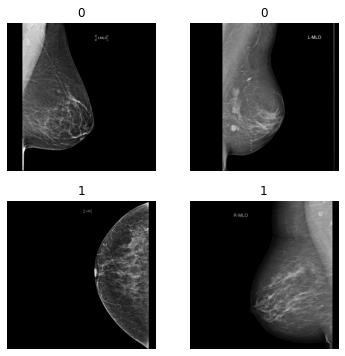

In [15]:
dls.show_batch(max_n=16)

In [16]:
def get_learner(arch=resnet18):
    learner = vision_learner(
        dls,
        arch,
        custom_head=nn.Sequential(SelectAdaptivePool2d(pool_type='avg', flatten=Flatten()), nn.Linear(1280, 2)),
        metrics=[
            error_rate,
            accuracy,
            F1Score()
        ],
        #loss_func=F.cross_entropy,
        #cbs=ActivationStats(with_hist=True),
        #loss_func=CrossEntropyLossFlat(weight=torch.tensor([1,50]).float()),
        pretrained=True,
        #normalize=False
    ).to_fp16()
    return learner

In [17]:
learn = get_learner('tf_efficientnetv2_s')

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_s-eb54923e.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_s-eb54923e.pth


In [18]:
#learn.summary()

In [19]:
#learn = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()

In [20]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [21]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(valley=0.001737800776027143)

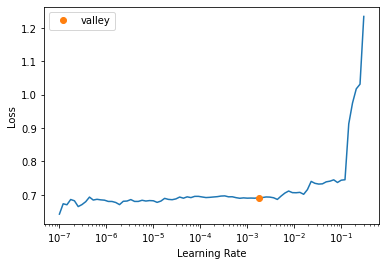

In [22]:
learn.lr_find()

In [23]:
# learn.unfreeze()
learn.fit_one_cycle(6, 0.001)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time
0,0.679465,0.677937,0.414687,0.585313,0.571429,04:01
1,0.675921,0.670773,0.419006,0.580994,0.645985,03:33
2,0.648039,0.669886,0.403888,0.596112,0.656881,03:31
3,0.646234,0.636719,0.369330,0.630670,0.620843,03:31
4,0.619804,0.637540,0.360691,0.639309,0.649895,03:31
5,0.629240,0.637820,0.354212,0.645788,0.678431,03:32


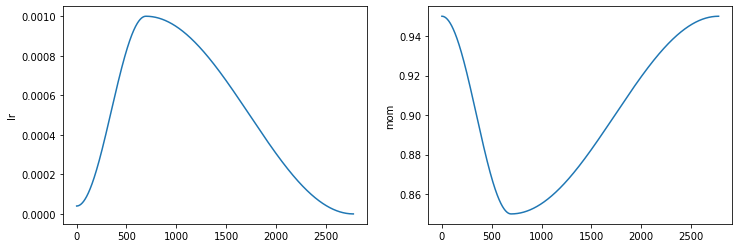

In [24]:
learn.recorder.plot_sched()

In [25]:
#learn.lr_find()

In [26]:
#learn.fit_one_cycle(6, 0.0006)

In [27]:
#learn.unfreeze()

In [28]:
#learn.lr_find()

In [29]:
#learn.fit_one_cycle(6, 1e-5)

In [30]:
#learn.recorder.plot_sched()

In [ ]:
#learn.activation_stats.plot_layer_stats(0)

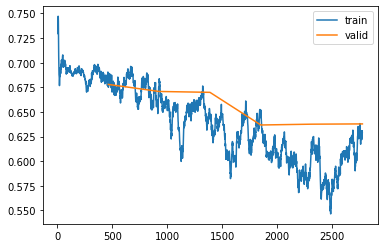

In [31]:
learn.recorder.plot_loss()

In [32]:
learn.save('us_1024_ch_enetv2s_ft', with_opt=False)

Path('models/us_1024_ch_enetv2s_ft.pth')

# Validation Data Metric

In [ ]:
# # # interp = ClassificationInterpretation.from_learner(learn)
# # # losses,idxs = interp.top_losses()
# # # len(dls.valid_ds)==len(losses)==len(idxs)
# # # interp.plot_confusion_matrix(figsize=(7,7))

# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()

In [ ]:
#interp.plot_top_losses(5, nrows=1)

# Test Data Metric

In [ ]:
# Class count
count_class_0_test, count_class_1_test = test_df.cancer.value_counts()

# Divide by class
df_class_0_test = test_df[test_df['cancer'] == 0]
df_class_1_test = test_df[test_df['cancer'] == 1]

In [ ]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under_test = df_class_0_test.sample(count_class_1_test, random_state=1)
df_test_under = pd.concat([df_class_0_under_test, df_class_1_test], axis=0)

print('Random under-sampling:')
print(df_test_under.cancer.value_counts())

In [ ]:
temp = learn.predict('/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_dicomsdl_512/train_images_processed_cv2_dicomsdl_512/10006/1459541791.png')
temp[0]

In [ ]:
def pfbeta(labels, predictions, beta):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(int(predictions[idx]), 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [ ]:
df_test_under.shape

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output

labels = []
preds = []

#preds = learn.predict(test_df['filepath'])
#labels = test_df['cancer']

for _, row in tqdm(df_test_under.iterrows()):
    pred = int(learn.predict(row.filepath)[0])
    preds.append(pred)
    label = row.cancer
    labels.append(label)
    clear_output(wait=True)

In [ ]:
type(pred)

In [ ]:
score = pfbeta(labels=labels, predictions=preds, beta=1)
print(score)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels, preds)